In [1]:
import optuna 
import lazypredict

import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split,cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler




In [2]:
data = pd.read_csv("customer_booking.csv", encoding="ISO-8859-1")
data.head

<bound method NDFrame.head of        num_passengers sales_channel  trip_type  purchase_lead  length_of_stay  \
0                   2      Internet  RoundTrip            262              19   
1                   1      Internet  RoundTrip            112              20   
2                   2      Internet  RoundTrip            243              22   
3                   1      Internet  RoundTrip             96              31   
4                   2      Internet  RoundTrip             68              22   
...               ...           ...        ...            ...             ...   
49995               2      Internet  RoundTrip             27               6   
49996               1      Internet  RoundTrip            111               6   
49997               1      Internet  RoundTrip             24               6   
49998               1      Internet  RoundTrip             15               6   
49999               1      Internet  RoundTrip             19               6  

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

In [4]:
data["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [5]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

data["flight_day"] = data["flight_day"].map(mapping)

In [6]:
data["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5], dtype=int64)

In [7]:
data.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


In [8]:
data.dtypes

num_passengers             int64
sales_channel             object
trip_type                 object
purchase_lead              int64
length_of_stay             int64
flight_hour                int64
flight_day                 int64
route                     object
booking_origin            object
wants_extra_baggage        int64
wants_preferred_seat       int64
wants_in_flight_meals      int64
flight_duration          float64
booking_complete           int64
dtype: object

In [9]:
# Check Class Imbalance
data['booking_complete'].value_counts(normalize=True) * 100

booking_complete
0    85.044
1    14.956
Name: proportion, dtype: float64

In [10]:
# Check Cardinality of All Features
data.nunique()

num_passengers             9
sales_channel              2
trip_type                  3
purchase_lead            470
length_of_stay           335
flight_hour               24
flight_day                 7
route                    799
booking_origin           104
wants_extra_baggage        2
wants_preferred_seat       2
wants_in_flight_meals      2
flight_duration           21
booking_complete           2
dtype: int64

In [11]:
# split route into origin and destination 
data[["origin", 'destination']] = data['route'].str.extract(r'([A-Z]{3})([A-Z]{3})')

In [12]:
# create time_of_day from flight_hour
def get_time_of_day(hour):
    if 5 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour <21:
        return 'Evening'
    else:
        return "Night"
    

data['time_of_day'] = data['flight_hour'].apply(get_time_of_day)

In [13]:
# create long_haul flag from flight_duration 
data['long_haul'] = data['flight_duration'].apply(lambda x: 1 if x >7 else 0)

In [14]:
# group less frequent as other 
top_countries = data['booking_origin'].value_counts().nlargest(10).index
data['booking_origin_grouped'] = data['booking_origin'].apply(lambda x: x if x in top_countries else 'Other')


In [15]:
# Preview new features
data[['route', 'origin', 'destination', 'flight_hour', 'time_of_day', 
    'flight_duration', 'long_haul', 'booking_origin', 'booking_origin_grouped']].head()

,route,origin,destination,flight_hour,time_of_day,flight_duration,long_haul,booking_origin,booking_origin_grouped
0,AKLDEL,AKL,DEL,7,Morning,5.52,0,New Zealand,New Zealand
1,AKLDEL,AKL,DEL,3,Night,5.52,0,New Zealand,New Zealand
2,AKLDEL,AKL,DEL,17,Evening,5.52,0,India,India
3,AKLDEL,AKL,DEL,4,Night,5.52,0,New Zealand,New Zealand
4,AKLDEL,AKL,DEL,15,Afternoon,5.52,0,India,India


In [16]:
# drop unused columns 
cleaned_data = data.drop(columns=[
    'route', 'booking_origin', 'flight_hour'
])

In [17]:
encoder = LabelEncoder()
categorical_columns = list(cleaned_data.select_dtypes(include='object').columns)
for col in categorical_columns:
    encoder.fit(cleaned_data[col])
    cleaned_data[col] = encoder.transform(cleaned_data[col])

In [18]:
cleaned_data.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,origin,destination,time_of_day,long_haul,booking_origin_grouped
0,2,0,2,262,19,6,1,0,0,5.52,0,0,4,2,0,6
1,1,0,2,112,20,6,0,0,0,5.52,0,0,4,3,0,6
2,2,0,2,243,22,3,1,1,0,5.52,0,0,4,1,0,2
3,1,0,2,96,31,6,0,0,1,5.52,0,0,4,3,0,6
4,2,0,2,68,22,3,1,0,1,5.52,0,0,4,0,0,2


In [19]:
data = cleaned_data

In [20]:
data.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,origin,destination,time_of_day,long_haul,booking_origin_grouped
0,2,0,2,262,19,6,1,0,0,5.52,0,0,4,2,0,6
1,1,0,2,112,20,6,0,0,0,5.52,0,0,4,3,0,6
2,2,0,2,243,22,3,1,1,0,5.52,0,0,4,1,0,2
3,1,0,2,96,31,6,0,0,1,5.52,0,0,4,3,0,6
4,2,0,2,68,22,3,1,0,1,5.52,0,0,4,0,0,2


In [21]:
# split dataset into X and y
X = data.drop(columns='booking_complete')
y = data['booking_complete']

In [22]:
# split dataset into train and test and stratify to maintain class balance 
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state= 23, stratify= y)

In [23]:
model = RandomForestClassifier(n_estimators=5, random_state=23,class_weight='balanced', max_depth=40)
model.fit(X_train,y_train)
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

In [24]:
# Evaluate the model
print(f'Train Classification Report')
print(classification_report(y_train, train_preds))

print(f'Test Classification Report')
print(classification_report(y_test, test_preds))

print(f'Confusion Matrix (Test)')
print(confusion_matrix(y_test, test_preds))

Train Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     34018
           1       0.97      0.86      0.92      5982

    accuracy                           0.98     40000
   macro avg       0.97      0.93      0.95     40000
weighted avg       0.98      0.98      0.98     40000

Test Classification Report
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      8504
           1       0.40      0.20      0.27      1496

    accuracy                           0.84     10000
   macro avg       0.64      0.57      0.59     10000
weighted avg       0.80      0.84      0.81     10000

Confusion Matrix (Test)
[[8066  438]
 [1198  298]]


In [ ]:

# Best model (example: Random Forest)
model = RandomForestClassifier(n_estimators=5, class_weight='balanced', random_state=23, max_depth=40)

# F1 scorer
f1 = make_scorer(f1_score, pos_label=1)

# Stratified 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Run cross-validation
scores = cross_val_score(model, X, y, scoring=f1, cv=cv)

print("Cross-validated F1 scores:", scores)
print("Average F1 score:", scores.mean())


Cross-validated F1 scores: [0.24511545 0.24517288 0.24822695 0.27756161 0.25314183]
Average F1 score: 0.253843744227331


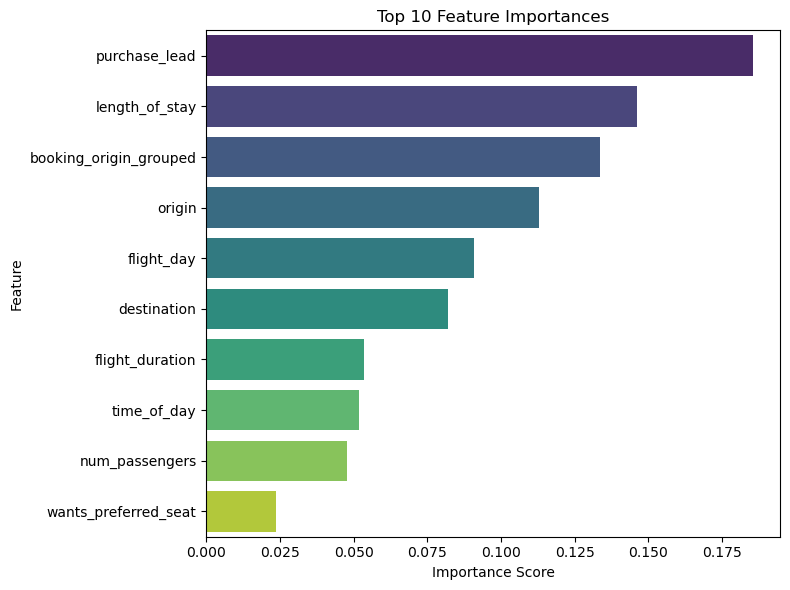

In [28]:
# Train on full data for importance plot
model.fit(X, y)

# Plot feature importances
import matplotlib.pyplot as plt
import seaborn as sns

# Create importance DataFrame
importances = pd.Series(model.feature_importances_, index=X.columns)
top_importances = importances.sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(x=top_importances.values, y=top_importances.index, palette='viridis')
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
